In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier

e:\Bootcamp\Titanic Spaceship\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargamos el archivo y comprobamos que los datos efectivamente están limpios

In [2]:
df = pd.read_csv('Train_recoded.csv')
df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
VIP             0
Name            0
Transported     0
Algun_Gasto     0
CabinDeck       0
CabinSide       0
Group           0
GroupNumber     0
Last Name       0
Solo            0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Gastos          0
CabinNumber     0
GroupSize       0
AgeGroup        0
dtype: int64

Recoficamos las variables categóricas en numéricas asignandoles valores numéricos en orden (0, 1, 2...)

In [3]:
df.loc[:, 'HomePlanet'] = df['HomePlanet'].map({'Europa': 0, 'Earth': 1, 'Mars': 2}).astype(int)
df.loc[:, 'CabinDeck'] = df['CabinDeck'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}).astype(int)
df.loc[:, 'CabinSide'] = df['CabinSide'].map({'P': 0, 'S': 1})
df.loc[:, 'CryoSleep'] = df['CryoSleep'].astype(int)
df.loc[:, 'Destination'] = df['Destination'].map({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2}).astype(int)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_14148\2690992866.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, 'CryoSleep'] = df['CryoSleep'].astype(int)


Separamos los conjuntos de entrenamiento y test, se eliminan además aquellas columnas que no vayan a usarse para el entrenamiento.

In [4]:
columnas_no_usadas = ["PassengerId", "Name", "Last Name", "Cabin"]

df = df.drop(columns = columnas_no_usadas)

y = df['Transported']
X = df.drop(['Transported'], axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [5]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print('Mejores hiperparámetros:', best_params)

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train)

[I 2024-09-25 03:38:38,245] A new study created in memory with name: no-name-cd727080-c1b2-4b79-b370-684089152016
[I 2024-09-25 03:38:41,006] Trial 0 finished with value: 0.8013327780091628 and parameters: {'iterations': 703, 'learning_rate': 0.17684725178393904, 'depth': 5, 'l2_leaf_reg': 3.3449840449181066e-05, 'border_count': 168}. Best is trial 0 with value: 0.8013327780091628.
[I 2024-09-25 03:38:41,736] Trial 1 finished with value: 0.8038317367763432 and parameters: {'iterations': 249, 'learning_rate': 0.0582657517456164, 'depth': 3, 'l2_leaf_reg': 0.0002802004784480371, 'border_count': 85}. Best is trial 1 with value: 0.8038317367763432.
[I 2024-09-25 03:38:42,580] Trial 2 finished with value: 0.8050812161599333 and parameters: {'iterations': 247, 'learning_rate': 0.19453068488946712, 'depth': 4, 'l2_leaf_reg': 0.07215149135872437, 'border_count': 234}. Best is trial 2 with value: 0.8050812161599333.
[I 2024-09-25 03:38:44,699] Trial 3 finished with value: 0.8084131611828405 and

Mejores hiperparámetros: {'iterations': 101, 'learning_rate': 0.21585621700495594, 'depth': 7, 'l2_leaf_reg': 0.375883343590983, 'border_count': 81}
0:	learn: 0.5814764	total: 4.38ms	remaining: 438ms
1:	learn: 0.5277859	total: 8.41ms	remaining: 416ms
2:	learn: 0.4923730	total: 12.4ms	remaining: 407ms
3:	learn: 0.4635911	total: 16.4ms	remaining: 398ms
4:	learn: 0.4417981	total: 20.5ms	remaining: 393ms
5:	learn: 0.4299365	total: 24.4ms	remaining: 386ms
6:	learn: 0.4206490	total: 28.1ms	remaining: 378ms
7:	learn: 0.4083319	total: 32ms	remaining: 372ms
8:	learn: 0.3996818	total: 35.5ms	remaining: 363ms
9:	learn: 0.3914230	total: 39.3ms	remaining: 357ms
10:	learn: 0.3877345	total: 43.1ms	remaining: 353ms
11:	learn: 0.3825037	total: 46.6ms	remaining: 346ms
12:	learn: 0.3786958	total: 50.2ms	remaining: 340ms
13:	learn: 0.3750807	total: 53.6ms	remaining: 333ms
14:	learn: 0.3706649	total: 57.4ms	remaining: 329ms
15:	learn: 0.3685567	total: 60.7ms	remaining: 323ms
16:	learn: 0.3654463	total: 64.

Sacamos los resultados de accuracy, validación cruzada y pintamos los gráficos de curva roc y matriz de confusión

In [10]:
y_pred_final = final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

cv_scores = cross_val_score(final_model, X, y, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

conf_matrix = confusion_matrix(y_test, y_pred_final)
class_report = classification_report(y_test, y_pred_final)

0:	learn: 0.6066400	total: 4.78ms	remaining: 478ms
1:	learn: 0.5421645	total: 8.99ms	remaining: 445ms
2:	learn: 0.5027656	total: 12.8ms	remaining: 418ms
3:	learn: 0.4699248	total: 17.1ms	remaining: 416ms
4:	learn: 0.4490317	total: 20.9ms	remaining: 402ms
5:	learn: 0.4351452	total: 24.6ms	remaining: 390ms
6:	learn: 0.4206567	total: 28.6ms	remaining: 385ms
7:	learn: 0.4101254	total: 33.1ms	remaining: 385ms
8:	learn: 0.4043353	total: 37.3ms	remaining: 381ms
9:	learn: 0.3996641	total: 41.4ms	remaining: 377ms
10:	learn: 0.3938985	total: 45.7ms	remaining: 374ms
11:	learn: 0.3875571	total: 49.4ms	remaining: 366ms
12:	learn: 0.3842930	total: 53.7ms	remaining: 364ms
13:	learn: 0.3799202	total: 57.5ms	remaining: 357ms
14:	learn: 0.3757280	total: 62.3ms	remaining: 357ms
15:	learn: 0.3714895	total: 66.9ms	remaining: 355ms
16:	learn: 0.3686102	total: 70.8ms	remaining: 350ms
17:	learn: 0.3663160	total: 75.2ms	remaining: 347ms
18:	learn: 0.3628158	total: 79.5ms	remaining: 343ms
19:	learn: 0.3601243	t

Precisión del modelo: 0.7921699291961682


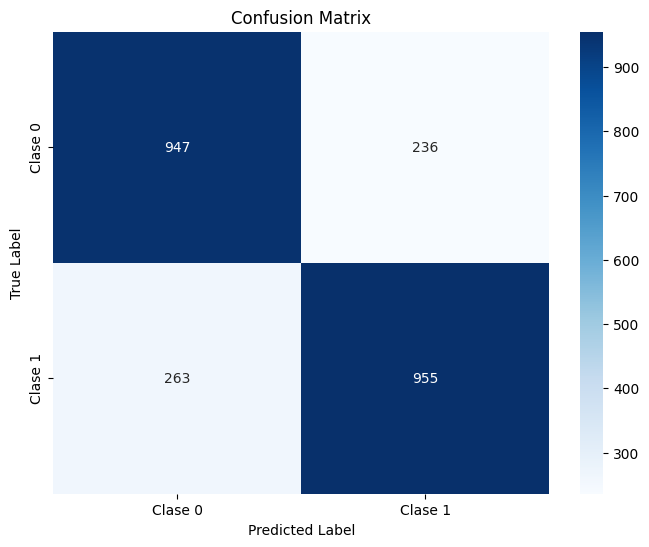

Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.78      0.80      0.79      1183
        True       0.80      0.78      0.79      1218

    accuracy                           0.79      2401
   macro avg       0.79      0.79      0.79      2401
weighted avg       0.79      0.79      0.79      2401



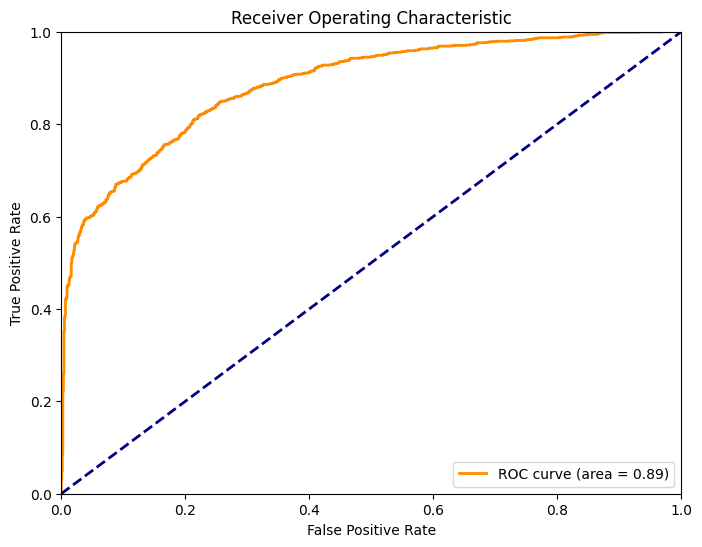

In [9]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_final}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Podemos hacer también un análisis de las features que hemos incluido en el modelo para comprobar si puede suprimirse alguna que no aporte al modelo.

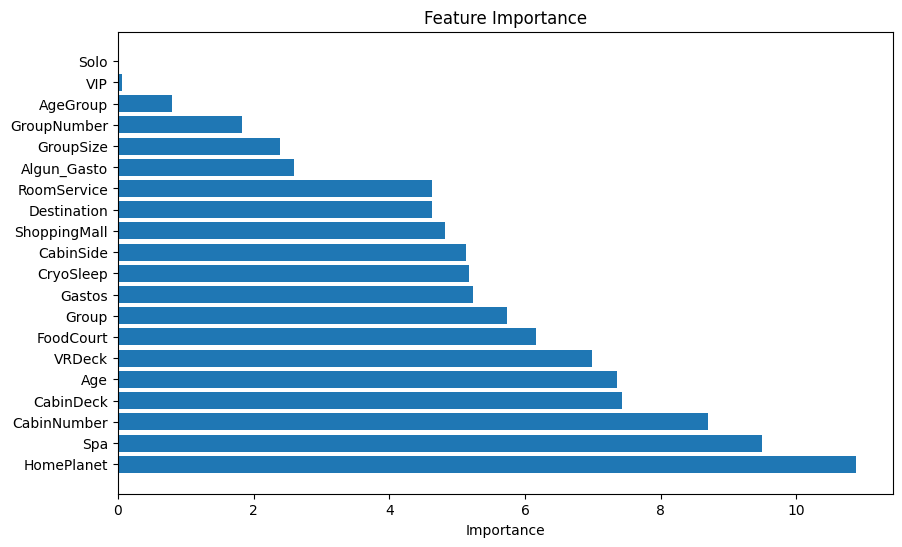

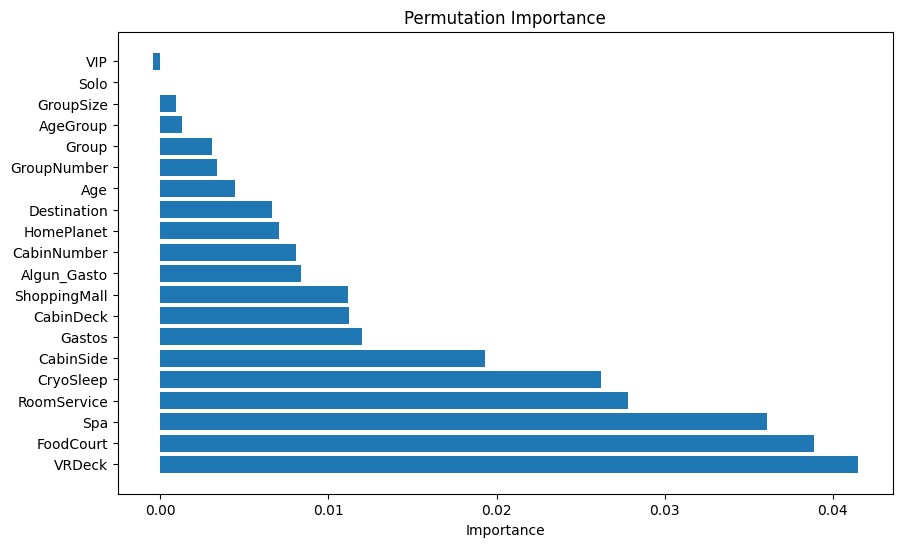

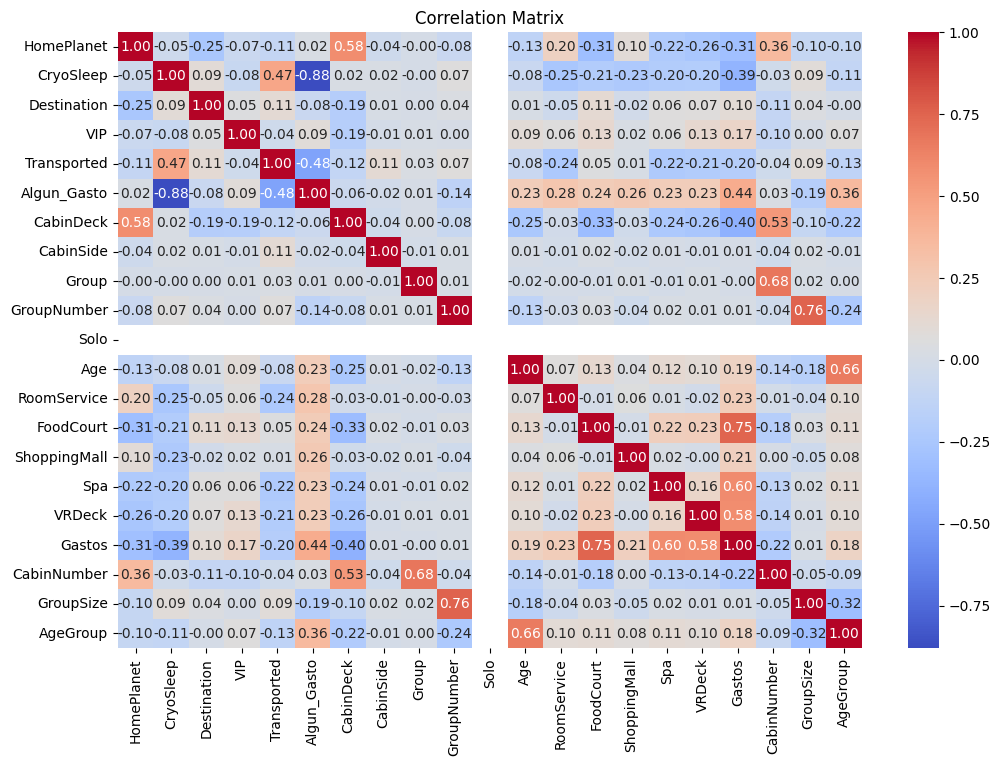

In [12]:
importances = final_model.get_feature_importance()

# Crear un DataFrame para facilitar la visualización
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

from sklearn.inspection import permutation_importance

# Obtener la importancia por permutación
result = permutation_importance(final_model, X_test, y_test, n_repeats=30, random_state=42)

# Crear un DataFrame con los resultados
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Graficar la importancia por permutación
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Permutation Importance')
plt.show()

correlation_matrix = df.corr()

# Graficar el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Parece que la variable de Solo no esta aportando nada al modelo, y se podría valorar también la exclusión de la variable VIP. Reentrenamos el modelo con esas condiciones.

In [23]:
features_eliminadas = ['Solo']

y = df['Transported']
X = df.drop(features_eliminadas + ['Transported'], axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [24]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print('Mejores hiperparámetros:', best_params)

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train)

[I 2024-09-25 04:14:53,499] A new study created in memory with name: no-name-8becfb76-f18e-430b-8632-16d7f89780b6
[I 2024-09-25 04:14:55,318] Trial 0 finished with value: 0.8000832986255727 and parameters: {'iterations': 414, 'learning_rate': 0.12740840402032474, 'depth': 5, 'l2_leaf_reg': 1.4217343863481075e-05, 'border_count': 176}. Best is trial 0 with value: 0.8000832986255727.
[I 2024-09-25 04:15:04,236] Trial 1 finished with value: 0.7988338192419825 and parameters: {'iterations': 957, 'learning_rate': 0.20416224428103966, 'depth': 9, 'l2_leaf_reg': 0.3302516417008277, 'border_count': 161}. Best is trial 0 with value: 0.8000832986255727.
[I 2024-09-25 04:15:06,646] Trial 2 finished with value: 0.8034152436484798 and parameters: {'iterations': 680, 'learning_rate': 0.12664508535453842, 'depth': 4, 'l2_leaf_reg': 0.0006254726532268115, 'border_count': 98}. Best is trial 2 with value: 0.8034152436484798.
[I 2024-09-25 04:15:07,658] Trial 3 finished with value: 0.8042482299042066 and

Mejores hiperparámetros: {'iterations': 298, 'learning_rate': 0.033067701612539205, 'depth': 7, 'l2_leaf_reg': 15.196542283148604, 'border_count': 139}
0:	learn: 0.6761494	total: 4.82ms	remaining: 1.43s
1:	learn: 0.6606182	total: 9.43ms	remaining: 1.4s
2:	learn: 0.6454396	total: 14.3ms	remaining: 1.41s
3:	learn: 0.6320079	total: 18.7ms	remaining: 1.37s
4:	learn: 0.6199910	total: 23ms	remaining: 1.34s
5:	learn: 0.6106836	total: 26.7ms	remaining: 1.3s
6:	learn: 0.6002128	total: 31.3ms	remaining: 1.3s
7:	learn: 0.5927118	total: 36.1ms	remaining: 1.31s
8:	learn: 0.5828400	total: 41.2ms	remaining: 1.32s
9:	learn: 0.5753726	total: 46.1ms	remaining: 1.33s
10:	learn: 0.5665668	total: 50.6ms	remaining: 1.32s
11:	learn: 0.5602110	total: 55ms	remaining: 1.31s
12:	learn: 0.5536368	total: 59.5ms	remaining: 1.3s
13:	learn: 0.5472639	total: 64.1ms	remaining: 1.3s
14:	learn: 0.5419160	total: 68.2ms	remaining: 1.28s
15:	learn: 0.5361170	total: 72.7ms	remaining: 1.28s
16:	learn: 0.5304156	total: 77.1ms	

In [25]:
y_pred_final = final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

cv_scores = cross_val_score(final_model, X, y, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

conf_matrix = confusion_matrix(y_test, y_pred_final)
class_report = classification_report(y_test, y_pred_final)

0:	learn: 0.6790892	total: 5.92ms	remaining: 1.76s
1:	learn: 0.6621478	total: 11.4ms	remaining: 1.68s
2:	learn: 0.6476364	total: 16.9ms	remaining: 1.67s
3:	learn: 0.6343688	total: 22.2ms	remaining: 1.63s
4:	learn: 0.6232783	total: 27.1ms	remaining: 1.59s
5:	learn: 0.6122987	total: 32.2ms	remaining: 1.57s
6:	learn: 0.6020637	total: 37.3ms	remaining: 1.55s
7:	learn: 0.5923693	total: 42.6ms	remaining: 1.54s
8:	learn: 0.5838105	total: 47ms	remaining: 1.51s
9:	learn: 0.5738988	total: 51.2ms	remaining: 1.47s
10:	learn: 0.5668983	total: 56.8ms	remaining: 1.48s
11:	learn: 0.5568790	total: 61.9ms	remaining: 1.47s
12:	learn: 0.5506992	total: 65.8ms	remaining: 1.44s
13:	learn: 0.5428288	total: 71.3ms	remaining: 1.45s
14:	learn: 0.5374419	total: 77.2ms	remaining: 1.46s
15:	learn: 0.5326017	total: 82.6ms	remaining: 1.46s
16:	learn: 0.5279408	total: 87.6ms	remaining: 1.45s
17:	learn: 0.5229592	total: 93.1ms	remaining: 1.45s
18:	learn: 0.5183418	total: 98.7ms	remaining: 1.45s
19:	learn: 0.5143810	tot

Precisión del modelo: 0.8084131611828405


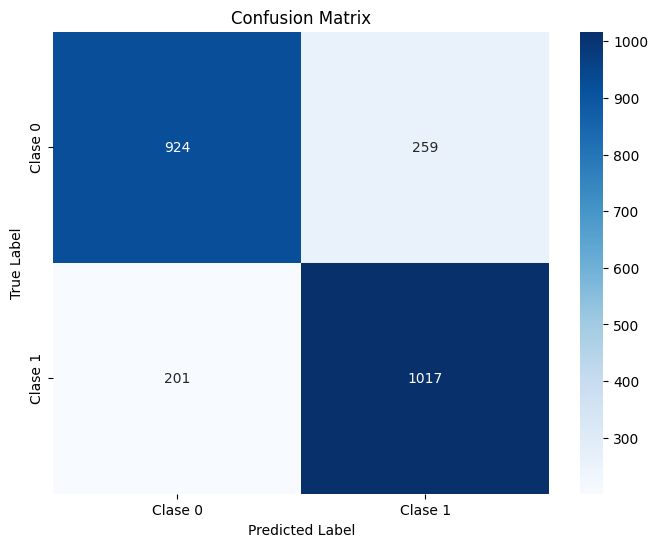

Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.82      0.78      0.80      1183
        True       0.80      0.83      0.82      1218

    accuracy                           0.81      2401
   macro avg       0.81      0.81      0.81      2401
weighted avg       0.81      0.81      0.81      2401



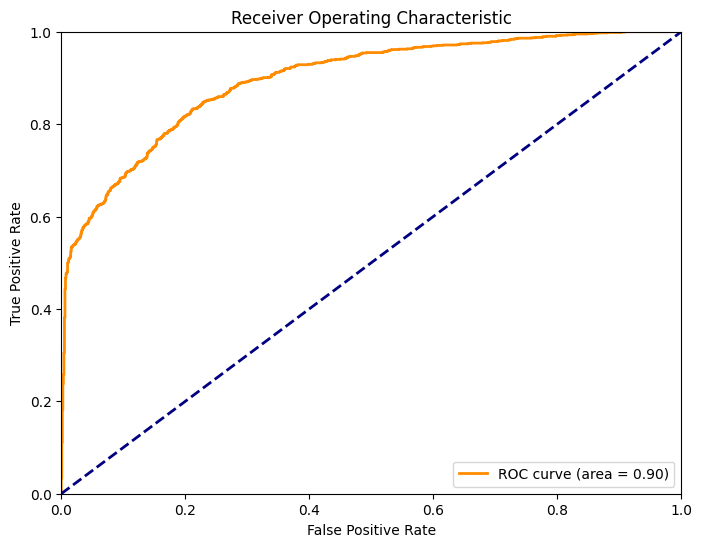

In [26]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_final}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

El ajuste parece mejor pero no mejora mucho la precisión del modelo. Podemos seguir valorando la exclusión de alguna variable pero probablemente solo consigamos bajar la precisión.

Una vez entrenado podemos aplicar el modelo a los datos

In [27]:
df_t = pd.read_csv('Test_recoded.csv')

df_test = df_t.drop(columns = ['Transported'] + columnas_no_usadas + features_eliminadas)

df_test.loc[:, 'HomePlanet'] = df_test['HomePlanet'].map({'Europa': 0, 'Earth': 1, 'Mars': 2}).astype(int)
df_test.loc[:, 'CabinDeck'] = df_test['CabinDeck'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}).astype(int)
df_test.loc[:, 'CabinSide'] = df_test['CabinSide'].map({'P': 0, 'S': 1}).astype(int)
df_test.loc[:, 'CryoSleep'] = df_test['CryoSleep'].astype(int)
df_test.loc[:, 'Destination'] = df_test['Destination'].map({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2}).astype(int)

df_test = df_test.astype(int)

prediccion = final_model.predict(df_test)

df_predict = pd.DataFrame({
    'PassengerId': df_t['PassengerId'],
    'Transported': prediccion.astype(bool)
})

df_predict.to_csv('prediccion_cat.csv', index = False)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_14148\2545412409.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 1 ... 1 0 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_test.loc[:, 'CryoSleep'] = df_test['CryoSleep'].astype(int)
